In [1]:
#imports
import math, copy, time
import torch, math
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch import Tensor,layer_norm
from torch.nn import functional as F
from torch.autograd import Variable
import preprocessing,note2vec

c:\Users\zsq59\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


worddict {(32, 1, 5, 4, 4): 0, (32, 0, 5, 12, 4): 1, (39, 0, 5, 20, 4): 2, (39, 2, 5, 28, 4): 3, (41, 1, 5, 4, 5): 4, (41, 0, 5, 12, 5): 5, (39, 2, 5, 20, 5): 6, (37, 1, 5, 4, 6): 7, (37, 0, 5, 12, 6): 8, (36, 0, 5, 20, 6): 9, (36, 2, 5, 28, 6): 10, (34, 1, 5, 4, 7): 11, (34, 0, 5, 12, 7): 12, (32, 2, 5, 20, 7): 13, (39, 1, 5, 4, 8): 14, (39, 0, 5, 12, 8): 15, (37, 0, 5, 20, 8): 16, (37, 2, 5, 28, 8): 17, (36, 1, 5, 4, 9): 18, (36, 0, 5, 12, 9): 19, (34, 2, 5, 20, 9): 20, (39, 1, 5, 4, 10): 21, (39, 0, 5, 12, 10): 22, (37, 0, 5, 20, 10): 23, (37, 2, 5, 28, 10): 24, (36, 1, 5, 4, 11): 25, (36, 0, 5, 12, 11): 26, (34, 2, 5, 20, 11): 27, (32, 1, 5, 4, 12): 28, (32, 0, 5, 12, 12): 29, (39, 0, 5, 20, 12): 30, (39, 2, 5, 28, 12): 31, (41, 1, 5, 4, 13): 32, (41, 0, 5, 12, 13): 33, (39, 2, 5, 20, 13): 34, (37, 1, 5, 4, 14): 35, (37, 0, 5, 12, 14): 36, (36, 0, 5, 20, 14): 37, (36, 2, 5, 28, 14): 38, (34, 1, 5, 4, 15): 39, (34, 0, 5, 12, 15): 40, (32, 2, 5, 20, 15): 41}
tensor([ 0.6113, -0.5005,

In [2]:
hidden_dim = 512
nhead = 8
nlayer=6
  # nlayer = 6
dim_feedforward = 2048
dropout = 0.1

  # original Training parameters
  # lr = 0.00001
  # epochs = 2000
epochs = 200
lr = 0.001

criterion = nn.CrossEntropyLoss()

In [4]:
### main functions###
def getDataLoader(data, batch_size):
  # loaded=torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=2)
  return torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=2)
def loadData(allTokensEvents,num_bar):
  X = []
  y = []
  for song in allTokensEvents:
    for i in range(len(song) - num_bar):
      src_bar = []
      for num in range(num_bar):
        src_bar += song[i + num]
      tgt_bar = song[i + num_bar] + [2]
      X.append(src_bar)
      y.append(tgt_bar)

  max_src_bar_len = len(max(X, key = len))
  max_tgt_bar_len = len(max(y, key = len))

  data = []
  for i in range(len(X)):
    src_notes = torch.LongTensor(X[i])
    tgt_notes = torch.LongTensor(y[i])

    src_full = torch.full((max_src_bar_len,), fill_value = 0)
    tgt_full = torch.full((max_tgt_bar_len,), fill_value = 0)

    src_full[:len(src_notes)] = src_notes
    tgt_full[:len(tgt_notes)] = tgt_notes
    data.append([src_full, tgt_full])
  dataloader_combined = getDataLoader(data, 2)
  return dataloader_combined
# clones
def clone(module, N):
  "Produce N identical layers."
  return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])
# mask
def subsequent_mask(size):
  attention_shape=(1,size, size)
  subsequent_mask= np.triu(np.ones(attention_shape),k=1).astype('uint8')
  return torch.from_numpy(1-subsequent_mask)
# attention🎶#
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [5]:
### main classes###
# layernorm
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        x=x[0]
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2
# embedding
class Embedding(nn.Module):
  def __init__(self, contextsize,embedding_dim, vocab):
    super(Embedding,self).__init__()
    self.lut,self.idx=note2vec.embed(contextsize,embedding_dim, vocab)
    self.embed_dim=embedding_dim
  def forward(self, input):
    return torch.tensor([[(self.lut[self.idx[tuple(i.tolist())]]*math.sqrt(self.embed_dim)).tolist() for i in input]])
  def unembed(self,input):
    return torch.tensor([list(self.idx.keys())[i] for i in input])
  def getidx(self,input):
    return torch.tensor([self.idx[tuple(i.tolist())]for i in input])
# positional encoding
class PosEncoding(nn.Module):
  def __init__(self, embedding_dim, dropout,max_len):
    super(PosEncoding,self).__init__()
    self.dropout=nn.Dropout(p=dropout)
    pe=torch.zeros(max_len, embedding_dim)
    position=torch.arange(0,max_len).unsqueeze(1)
    half=torch.exp(torch.arange(0, embedding_dim, 2)* -(math.log(1000.0/embedding_dim)))
    pe[:,0::2]=torch.sin(position*half)
    pe[:,1::2]=torch.cos(position*half)
    pe=pe.unsqueeze(0)
    ####
    self.register_buffer('pe',pe)
  def forward(self,input):
    input=input+Variable(self.pe[:,:input.size(1)],requires_grad=False)
    return self.dropout(input)
# sublayer connection
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

class MultiHeadedAttention(nn.Module):
    def __init__(self, nhead, embedding_dim, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert embedding_dim % nhead == 0
        # We assume d_v always equals d_k
        self.d_k = embedding_dim // nhead
        self.h = nhead
        temlinear=nn.Linear(embedding_dim, embedding_dim)
        self.linears = clone(temlinear, 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        query=torch.tensor([query.tolist()])
        key=torch.tensor([key.tolist()])
        value=torch.tensor([value.tolist()])
        # print("q",query,query.shape)
        # print("k",key,key.shape)
        # print("v",value,value.shape)
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        
        lx=[l(x) for l, x in zip(self.linears, (query, key, value))]
        # print("lx",lx,[l.shape for l in lx])
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)
#FFW#
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, embedding_dim, dim_feedforward, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(embedding_dim, dim_feedforward)
        self.w_2 = nn.Linear(dim_feedforward, embedding_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

# encoder
class Encoder(nn.Module):
  def __init__(self, encoderlayer, nhead):
    super(Encoder,self).__init__()
    self.layers=clone(encoderlayer,nhead)
    self.norm=LayerNorm(encoderlayer.size)
  def forward(self, encoder_input,mask):
    for layer in self.layers:
      encoder_input=layer(encoder_input,mask)
    return self.norm(encoder_input)
class EncoderLayer(nn.Module):
    "Encoder = self-attn + feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clone(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        # print("encoderQVK",x,x.shape)
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        # print("postx",x,x.shape)
        return self.sublayer[1](x, self.feed_forward)
# decoder
class Decoder(nn.Module):
  def __init__(self, decoderlayer, N):
    super(Decoder, self).__init__()
    self.layers = clone(decoderlayer, N)
    self.norm = LayerNorm(decoderlayer.size)
  def forward(self, decoder_input,encoder_input,src_mask,tgt_mask):
    for layer in self.layers:
      decoder_input = layer(decoder_input, encoder_input, src_mask, tgt_mask)
    return self.norm(decoder_input)
    
class EncoderDecoderLayer(nn.Module):
  def __init__(self,size, self_attn,src_attn,feedforward,dropout):
    super(EncoderDecoderLayer, self).__init__()
    self.size=size
    self.self_attn=self_attn
    self.src_attn=src_attn
    self.feedforward=feedforward
    self.sublayer=clone(SublayerConnection(size, dropout),3)
  def forward(self, decoder_input,encoder_input,src_mask,tgt_mask):
    d=decoder_input
    d = self.sublayer[0](d, lambda d: self.self_attn(d, d, d, tgt_mask))
    d = self.sublayer[1](d, lambda d: self.src_attn(d, encoder_input, encoder_input, src_mask))
    return self.sublayer[2](d, self.feedforward)


In [6]:
# model

class MusicTransformer(nn.Module):
  def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
    super(MusicTransformer, self).__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.tgt_embed = tgt_embed
    self.generator = generator
  def create_mask(self, src, tgt):
    tgt_mask = self.transformer.generate_square_subsequent_mask(tgt.shape[1])
    src_padding_mask = (src == 0)
    tgt_padding_mask = (tgt == 0)
    return tgt_mask, src_padding_mask, tgt_padding_mask
  def maskall(self,size):
    allones=torch.zeros(1,size,size)
    return (allones!=0)
  def forward(self, src, tgt,train):
    "Take in and process masked src and target sequences."
    if train:
      # src_mask=(src == 0)
      src_mask=None
      # src_mask=None
      # for i in range(src_mask.size(1)):
      #   src_mask[0][i]=[1]if s=='True' else 0 for s in src_mask[0][i]]
      # src_mask=torch.matmul(src_mask, src_mask.transpose(-2, -1))
      # tgt_mask =subsequent_mask(tgt.shape[1])
      
      tgt_mask =subsequent_mask(len(tgt))
      # tgt_mask=None
      # tgt_mask = torch.transformer.generate_square_subsequent_mask(tgt.shape[1])
      test=self.decode(self.encode(src, src_mask), src_mask,tgt,tgt_mask)
      # print("previewtrain",test,test.shape)
      # return self.decode(self.encode(src, src_mask), src_mask,tgt,tgt_mask)
      return torch.tensor([test.tolist()])
  
    else:
      # tgt_mask=self.maskall(tgt.shape[1])
      tgt_mask=None
      # print(tgt_mask)
      test1=self.decode(self.encode(src, None), None,tgt,tgt_mask)
      # return self.decode(self.encode(src, None), None,tgt,tgt_mask)
      return torch.tensor([test1.tolist()])

    # return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)
    
  def encode(self, src, src_mask):
    return self.encoder(self.src_embed[0](src), src_mask)
    
  def decode(self, memory, src_mask,tgt,tgt_mask):
    return self.decoder(self.tgt_embed[0](tgt), memory, src_mask, tgt_mask)

In [7]:
### train and generation ###
# not used
def train_epoch(iterations, model, lossfn):
  start = time.time()
  total_tokens = 0
  total_loss = 0
  tokens = 0
  for i, batch in enumerate(iterations):
    out = model.forward(batch.src, batch.trg, batch.src_mask, batch.trg_mask)
    loss = lossfn(out, batch.trg_y, batch.ntokens)
    total_loss += loss
    total_tokens += batch.ntokens
    tokens += batch.ntokens
    if i % 10 == 1:
      elapsed = time.time() - start
      print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %(i, loss / batch.ntokens, tokens / elapsed))
      start = time.time()
      tokens = 0
    return total_loss / total_tokens

# generation
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.vocab=vocab
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        # print("softmax",F.log_softmax(self.proj(x), dim=-1))
        # newthing=nn.Linear(x.size(1),self.vocab)
        # print(newthing(x),newthing(x).size())
        # return F.log_softmax(newthing(x), dim=1)
        return F.softmax(self.proj(x), dim=1)
        # return F.log_softmax(self.proj(x), dim=1)

In [8]:
def make_model(src_vocab, tgt_vocab,nlayer, embedding_dim,dim_feedforward,nhead,dropout,max_len):
  c = copy.deepcopy
  attn = MultiHeadedAttention(nhead, embedding_dim)
  ff = PositionwiseFeedForward(embedding_dim, dim_feedforward, dropout)
  position = PosEncoding(embedding_dim, dropout, max_len)
  
  src_embed=nn.Sequential(Embedding(2,embedding_dim, src_vocab), c(position))
  tgt_embed=nn.Sequential(Embedding(2,embedding_dim, tgt_vocab), c(position))
  model = MusicTransformer(
        Encoder(EncoderLayer(embedding_dim, c(attn), c(ff), dropout), nlayer),
        Decoder(EncoderDecoderLayer(embedding_dim, c(attn), c(attn), c(ff), dropout), nlayer),
        src_embed,
        tgt_embed,
        Generator(embedding_dim,max_len))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
  # for p in model.parameters():
  #   if p.dim() > 1:
  #     nn.init.xavier_uniform(p)
  return model

In [9]:
def run_epoch(epochs,dataloader, model):
  for epoch in range(1, 1 + epochs):
    train_epoch_loss = 0
    num_correct = 0
    num_total = 0
    model.train()
    for i, (src, tgt) in enumerate(dataloader):
      optimizer.zero_grad()
      # print("src,tgt",src,tgt)
      output = model(src, tgt,True)
      # print("predout",output,output.size())
      newoutput=model.generator(output)
      # output=torch.tensor([output.tolist()])
      # print("output",newoutput,newoutput.size())
      final_token=torch.argmax(newoutput, dim = 2).data
      # print("finaltoken",final_token,final_token.shape)
      target=model.tgt_embed[0].getidx(tgt)
      # target=model.tgt_embed[0].forward(tgt)
      # print("tgt",target,target.shape)
      a=newoutput.contiguous().view(-1, newoutput.size(-1))
      b=target.contiguous().view(-1) 
      # print("a",a,a.shape,"b",b,b.shape)
      loss = criterion(a, b)
      loss.backward()
      # print("loss",loss.item())
      
      optimizer.step()

      train_epoch_loss += loss.item()
     
      finalconverted=model.src_embed[0].unembed(final_token[0])
      # print("final",finalconverted,"target",tgt)
      num_correct += torch.sum(finalconverted == tgt)
      num_total+=len(target)
    model.eval()
    outputs.append(output)
    train_loss.append(train_epoch_loss)
    train_acc.append(num_correct/num_total)
    if epoch % 2 == 0:
      print('EPOCH %i' % (epoch))
      print("Train loss: %f" % (train_loss[epoch - 1]))
      print("Train acc: %f" % (train_acc[epoch - 1]))
      torch.save(model.state_dict(), './data/modelStates/note2veclowerlr')
      if epoch % 4 == 0:
        final_token=torch.argmax(newoutput, dim = 2).data
        finalconverted=model.src_embed[0].unembed(final_token[0])
        print("Predictions:",finalconverted)
        # print("Predictions:", torch.argmax(output, dim = 2))#change to softmax
        # encoderHeat(testMod,6,2,tokenEvents)
        # decoderHeat(testMod,6,2,tokenEvents,tokenEvents)
        print("Target:", tgt)
  torch.save(model.state_dict(),'./data/modelStates/note2veclowerlr')

def makeTensor(X,y,max_src_bar_len,max_tgt_bar_len):
  data = []
  for i in range(len(X)):
    src_notes = torch.LongTensor(X[i])
    tgt_notes = torch.LongTensor(y[i])

    src_full = torch.full((max_src_bar_len,), fill_value = 0)
    tgt_full = torch.full((max_tgt_bar_len,), fill_value = 0)

    src_full[:len(src_notes)] = src_notes
    tgt_full[:len(tgt_notes)] = tgt_notes
    data.append([src_full, tgt_full])
  return data

In [11]:
data_path1 = './data/testmidi.mid'
# data_path1 = './data/bach/fp-4bou.mid'
data_path2 = './data/bach/fp-3sar.mid'
barnum=2
tokenEvents1=preprocessing.tokenizeSOSEOS(data_path1)
tokenEvents2=preprocessing.tokenizeSOSEOS(data_path2)
initbarnum=tokenEvents1[0][-1]
initpos=tokenEvents1[0][-2]
print(initbarnum,initpos)
# tokenEvents1=[tuple(a) for a in tokenEvents1]
# tokenEvents1=note2vec.embed(2,128,tokenEvents1)
# tokenEvents1=[x[:-1] for x in tokenEvents1]
# numbarXY1=preprocessing.note2vecNote(tokenEvents1,5)

numbarXY1=preprocessing.note2vecNumBarRelative([x[:-2] for x in tokenEvents1],2)
numbarXY2=preprocessing.note2vecNumBarRelative(tokenEvents2,2)
print("note2vecds",numbarXY1)
X1=[l[0] for l in numbarXY1]
Y1=[l[1] for l in numbarXY1]
X2=[l[0] for l in numbarXY2]
Y2=[l[1] for l in numbarXY2]
print("x1",X1)
print("y1",Y1)
# print("x2",X2)
# print("y2",Y2)
# maxbarlen=len(max(X1+Y1, key = len))//5
# print(maxbarlen)

# data1=[[torch.LongTensor(X1[i]),torch.LongTensor(Y1[i])]for i in range(len(X1))]
# data2=[[torch.LongTensor(X2[i]),torch.LongTensor(Y2[i])]for i in range(len(X2))]
# dataloader=getDataLoader(data1,1)
# dataloader=getDataLoader(X1,1)


alltokens=[]
alltokens+=[tok for tok in tokenEvents1 if tok not in alltokens]
alltokens+=[tok for tok in tokenEvents2 if tok not in alltokens]
print(len(alltokens))

# num_events = len(alltokens)
num_events=len(tokenEvents1)
print(num_events)
embedding_dim=128

4 4
note2vecds [[tensor([[32,  1,  5],
        [32,  0,  5],
        [39,  0,  5],
        [39,  2,  5],
        [41,  1,  5],
        [41,  0,  5],
        [39,  2,  5]]), tensor([[37,  1,  5],
        [37,  0,  5],
        [36,  0,  5],
        [36,  2,  5]])], [tensor([[41,  1,  5],
        [41,  0,  5],
        [39,  2,  5],
        [37,  1,  5],
        [37,  0,  5],
        [36,  0,  5],
        [36,  2,  5]]), tensor([[34,  1,  5],
        [34,  0,  5],
        [32,  2,  5]])], [tensor([[37,  1,  5],
        [37,  0,  5],
        [36,  0,  5],
        [36,  2,  5],
        [34,  1,  5],
        [34,  0,  5],
        [32,  2,  5]]), tensor([[39,  1,  5],
        [39,  0,  5],
        [37,  0,  5],
        [37,  2,  5]])], [tensor([[34,  1,  5],
        [34,  0,  5],
        [32,  2,  5],
        [39,  1,  5],
        [39,  0,  5],
        [37,  0,  5],
        [37,  2,  5]]), tensor([[36,  1,  5],
        [36,  0,  5],
        [34,  2,  5]])], [tensor([[39,  1,  5],
        [39, 

In [12]:
class noteDataset():
    def __init__(self,numbarXY) -> None:
        self.x=[l[0] for l in numbarXY]
        self.y=[l[1] for l in numbarXY]
        self.n_samples=len(numbarXY)

    def __getitem__(self,index):
        return self.x[index],self.y[index]
    def __len__(self):
        return self.n_samples

In [13]:
#making testmod
# Metrics to evaluate model
train_loss = []
train_acc = []
outputs = []
# maxtok=max(tokenEvents)[0]
# print(maxtok)
src_vocab=[]
for x in [a[:-2] for a in tokenEvents1]:
    if x not in src_vocab:
        src_vocab.append(x)
src_vocab=list(src_vocab)
# tgt_vocab=list(src_vocab)

# print("srcvocabs",src_vocab)
# print("tgtvocabs",tgt_vocab)
testMod=make_model(src_vocab,src_vocab,nlayer, embedding_dim,dim_feedforward,nhead,dropout,max_len=len(src_vocab))
optimizer = torch.optim.Adam(testMod.parameters(), lr= lr)
#check src and tgt embedding
# print("src",testMod.src_embed.size(),"tgt",testMod.tgt_embed.size())
# print(inputx,src_embed(inputx),tgt_embed)


worddict {(32, 1, 5): 0, (32, 0, 5): 1, (39, 0, 5): 2, (39, 2, 5): 3, (41, 1, 5): 4, (41, 0, 5): 5, (37, 1, 5): 6, (37, 0, 5): 7, (36, 0, 5): 8, (36, 2, 5): 9, (34, 1, 5): 10, (34, 0, 5): 11, (32, 2, 5): 12, (39, 1, 5): 13, (37, 2, 5): 14, (36, 1, 5): 15, (34, 2, 5): 16}
worddict {(32, 1, 5): 0, (32, 0, 5): 1, (39, 0, 5): 2, (39, 2, 5): 3, (41, 1, 5): 4, (41, 0, 5): 5, (37, 1, 5): 6, (37, 0, 5): 7, (36, 0, 5): 8, (36, 2, 5): 9, (34, 1, 5): 10, (34, 0, 5): 11, (32, 2, 5): 12, (39, 1, 5): 13, (37, 2, 5): 14, (36, 1, 5): 15, (34, 2, 5): 16}


In [14]:
run_epoch(epochs, numbarXY1, testMod)

EPOCH 2
Train loss: 25.169168
Train acc: 1.875000
EPOCH 4
Train loss: 23.180627
Train acc: 2.531250
Predictions: tensor([[37,  1,  5],
        [41,  0,  5],
        [36,  0,  5],
        [36,  2,  5]])
Target: tensor([[37,  1,  5],
        [37,  0,  5],
        [36,  0,  5],
        [36,  2,  5]])
EPOCH 6
Train loss: 21.497553
Train acc: 2.843750
EPOCH 8
Train loss: 20.516014
Train acc: 3.000000
Predictions: tensor([[37,  1,  5],
        [37,  0,  5],
        [36,  0,  5],
        [36,  2,  5]])
Target: tensor([[37,  1,  5],
        [37,  0,  5],
        [36,  0,  5],
        [36,  2,  5]])
EPOCH 10
Train loss: 20.055729
Train acc: 3.000000
EPOCH 12
Train loss: 19.828285
Train acc: 3.000000
Predictions: tensor([[37,  1,  5],
        [37,  0,  5],
        [36,  0,  5],
        [36,  2,  5]])
Target: tensor([[37,  1,  5],
        [37,  0,  5],
        [36,  0,  5],
        [36,  2,  5]])
EPOCH 14
Train loss: 19.694635
Train acc: 3.000000
EPOCH 16
Train loss: 19.626167
Train acc: 3.000000

visualizations

In [146]:
#attention visualization
import seaborn
import matplotlib.pyplot as plt

def draw(data, x, y, ax):
    seaborn.heatmap(data, 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False, ax=ax)
def encoderHeat(testMod,layers,skipby,sent):
    for layer in range(0, layers, skipby):
        fig, axs = plt.subplots(1,4, figsize=(20, 10))
        print("Encoder Layer", layer+1)
        for h in range(4):
            draw(testMod.encoder.layers[layer].self_attn.attn[0, h].data, 
                sent, sent if h ==0 else [], ax=axs[h])
        plt.show()
def decoderHeat(testMod,layers,skipby,sent,tgt_sent):   
    for layer in range(0, layers, skipby):
        fig, axs = plt.subplots(1,4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(testMod.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(tgt_sent)], 
                tgt_sent, tgt_sent if h ==0 else [], ax=axs[h])
        plt.show()
        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1,4, figsize=(20, 10))
        for h in range(4):
            draw(testMod.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(sent)], 
                sent, tgt_sent if h ==0 else [], ax=axs[h])
        plt.show()

KeyboardInterrupt: 

In [ ]:
inputbar=numbarXY[0][0]
tgtbar=numbarXY[0][1]
print(testMod.encoder.layers[0].self_attn.attn)

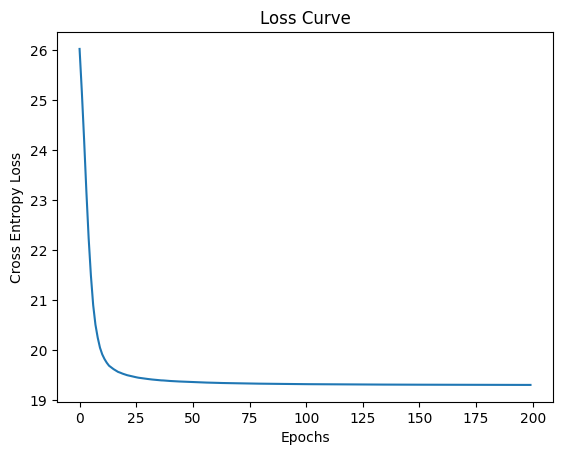

In [15]:
#plots
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.show()

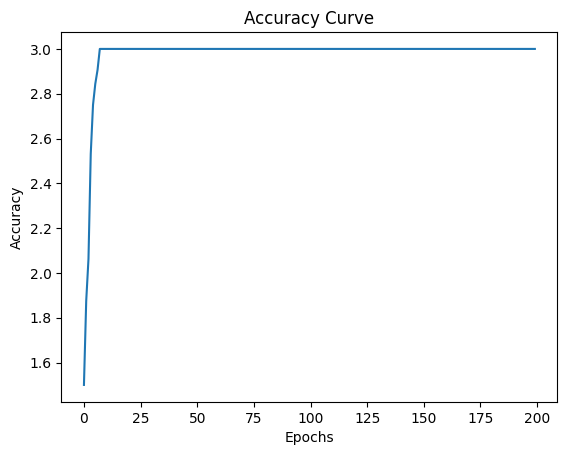

In [16]:
plt.plot(train_acc)
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

generation

In [12]:
# model = testMod(num_events, hidden_dim, nhead, nlayer, dim_feedforward, dropout)
# for when you leave and come back so you don't have to re-train
testMod.load_state_dict(torch.load('./data/modelStates/note2vec1'))

<All keys matched successfully>

In [18]:
import pprint
inputbar=X1[0]
tgtbar=Y1[0]
print("allpossibletok",tokenEvents1)
print(inputbar,tgtbar)
iter=8
lastbarnum=initbarnum
sliceidx=0
generated_song=[inputbar.tolist()][0]
print("generated_song",generated_song)
barcount=0
for f in range(iter):
    print("iteration",f)
    prob_tokens = testMod(torch.LongTensor(inputbar).unsqueeze(0)[0], torch.LongTensor(tgtbar).unsqueeze(0)[0], train = False)
    prob=testMod.generator(prob_tokens)
    #--------------------------------------
    idxs=[i for i in range(0,len(src_vocab))]
    newprob=[newp.tolist() for newp in prob[0]]
    for i in range(len(newprob)):
        #first filter
        probsum=sum(newprob[i])
        probavg=probsum/len(newprob[i])    
        for n in range(len(newprob[i])):
            if newprob[i][n]<max(newprob[i]):#1.5*probavg
                newprob[i][n]=0
        #then normalize
        probsum=sum(newprob[i])
        for j in range(len(newprob[i])):
            newprob[i][j]=newprob[i][j]/probsum
        print("newprob",len(newprob[i]))
        pprint.pprint([(testMod.src_embed[0].unembed([k]),newprob[i][k]) for k in range(len(newprob[i]))])
    
    newbar=[np.random.choice(idxs,p=normalp) for normalp in newprob]
    print("newbar",newbar)
    comp=testMod.src_embed[0].unembed(newbar)
    print("comp",comp)
    final_token=comp.tolist()
    generated_song+=final_token
    print("gen",generated_song)
    tgtbar=Y1[f+1]
    inputbar=generated_song[4:] #+generated_song[-1]
    print("newin",inputbar)
print(generated_song)

allpossibletok [[32, 1, 5, 4, 4], [32, 0, 5, 12, 4], [39, 0, 5, 20, 4], [39, 2, 5, 28, 4], [41, 1, 5, 4, 5], [41, 0, 5, 12, 5], [39, 2, 5, 20, 5], [37, 1, 5, 4, 6], [37, 0, 5, 12, 6], [36, 0, 5, 20, 6], [36, 2, 5, 28, 6], [34, 1, 5, 4, 7], [34, 0, 5, 12, 7], [32, 2, 5, 20, 7], [39, 1, 5, 4, 8], [39, 0, 5, 12, 8], [37, 0, 5, 20, 8], [37, 2, 5, 28, 8], [36, 1, 5, 4, 9], [36, 0, 5, 12, 9], [34, 2, 5, 20, 9], [39, 1, 5, 4, 10], [39, 0, 5, 12, 10], [37, 0, 5, 20, 10], [37, 2, 5, 28, 10], [36, 1, 5, 4, 11], [36, 0, 5, 12, 11], [34, 2, 5, 20, 11], [32, 1, 5, 4, 12], [32, 0, 5, 12, 12], [39, 0, 5, 20, 12], [39, 2, 5, 28, 12], [41, 1, 5, 4, 13], [41, 0, 5, 12, 13], [39, 2, 5, 20, 13], [37, 1, 5, 4, 14], [37, 0, 5, 12, 14], [36, 0, 5, 20, 14], [36, 2, 5, 28, 14], [34, 1, 5, 4, 15], [34, 0, 5, 12, 15], [32, 2, 5, 20, 15]]
tensor([[32,  1,  5],
        [32,  0,  5],
        [39,  0,  5],
        [39,  2,  5],
        [41,  1,  5],
        [41,  0,  5],
        [39,  2,  5]]) tensor([[37,  1,  5],


In [19]:
print(generated_song)
lastbarnum=initbarnum
lastpos=initpos
DP=preprocessing.DPmapping([f[:-1] for f in tokenEvents1])
print(DP)
for i in range(len(generated_song)):
    generated_song[i]+=[lastpos]
    lastpos+=DP[generated_song[i][-2]]
    if generated_song[i][1]==2:
        generated_song[i]+=[lastbarnum]
        lastbarnum+=1
        lastpos=initpos
    else:
        generated_song[i]+=[lastbarnum]
    generated_song[i][1]=16

print(generated_song)


[[32, 1, 5], [32, 0, 5], [39, 0, 5], [39, 2, 5], [41, 1, 5], [41, 0, 5], [39, 2, 5], [37, 1, 5], [37, 0, 5], [36, 0, 5], [36, 2, 5], [34, 1, 5], [34, 0, 5], [32, 2, 5], [39, 1, 5], [39, 0, 5], [37, 0, 5], [37, 2, 5], [36, 1, 5], [36, 0, 5], [34, 2, 5], [39, 1, 5], [39, 0, 5], [37, 0, 5], [37, 2, 5], [36, 1, 5], [36, 0, 5], [34, 2, 5], [32, 1, 5], [32, 0, 5], [39, 0, 5], [39, 2, 5], [41, 1, 5], [41, 0, 5], [39, 2, 5]]
{5: 8}
[[32, 16, 5, 4, 4], [32, 16, 5, 12, 4], [39, 16, 5, 20, 4], [39, 16, 5, 28, 4], [41, 16, 5, 4, 5], [41, 16, 5, 12, 5], [39, 16, 5, 20, 5], [37, 16, 5, 4, 6], [37, 16, 5, 12, 6], [36, 16, 5, 20, 6], [36, 16, 5, 28, 6], [34, 16, 5, 4, 7], [34, 16, 5, 12, 7], [32, 16, 5, 20, 7], [39, 16, 5, 4, 8], [39, 16, 5, 12, 8], [37, 16, 5, 20, 8], [37, 16, 5, 28, 8], [36, 16, 5, 4, 9], [36, 16, 5, 12, 9], [34, 16, 5, 20, 9], [39, 16, 5, 4, 10], [39, 16, 5, 12, 10], [37, 16, 5, 20, 10], [37, 16, 5, 28, 10], [36, 16, 5, 4, 11], [36, 16, 5, 12, 11], [34, 16, 5, 20, 11], [32, 16, 5, 

In [20]:
testmidi=preprocessing.tokenizer.tokens_to_midi([generated_song])
testmidi.dump('test_clean.mid')